In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import glob
from model import RED_CNN
from CTImage import CTImage
import torch.nn as nn
from tqdm.auto import tqdm
from utils import cal_SSIM,cal_PSNR,SSIM

In [ ]:
os.chdir('/remote-home/fangkejie/LDCT/LDCT')

In [4]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = RED_CNN().to(device)
train_dataset = CTImage(patch_n=10,patch_size=64)
val_dataset = CTImage(patch_n=None,patch_size=None,root_dir='../data/ValSet')

# path = 'saved_file/ssim_model80.pth'
# model.load_state_dict(torch.load(path))

def train(loss_function = 'MSE',patch_train=True,epochs=100,lr=1e-5, decay_iters = 3000):
    train_losses = []
    total_iters = 0
    patch_size = 64
    patch_n = 10
    iters_num = 0
    print_iter = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    ssim = SSIM()
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


    for epoch in range(epochs):
        print('epoch:{}'.format(epoch))
        for i, data in tqdm(enumerate(train_loader),total=len(train_loader)):
            iters_num += 1
            inputs = data[0]
            targets = data[1]
            if patch_train:
                inputs = inputs.view(-1, 1, patch_size, patch_size)
                targets = targets.view(-1, 1, patch_size, patch_size)
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            if loss_function == 'MSE':
                loss = criterion(outputs, targets)
            elif loss_function == 'SSIM':
                loss = 1 - ssim(outputs,targets)
            loss.backward()
            optimizer.step()

        
        print('epoch: {}, loss: {:.4}'.format(epoch, loss.item()))

        avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(val_dataset)
        print(avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), 'saved_file/ssim_model2_{}.pth'.format(epoch+1))

In [2]:
def test(testset,batch_size=16):
    dataloader = DataLoader(testset,batch_size=16,shuffle=False)
    total_origin_PSNR = 0
    total_PSNR = 0
    total_origin_SSIM = 0
    total_SSIM = 0
    cnt = 0
    with torch.no_grad():
        for _,batch in tqdm(enumerate(dataloader),total=len(dataloader)):
            targets = batch[1].to(device)
            inputs = batch[0].to(device)
            outputs = model(inputs).detach()
            for i in range(targets.shape[0]):
                total_origin_PSNR += cal_PSNR(inputs[i],targets[i])
                total_origin_SSIM += cal_SSIM(inputs[i],targets[i])
                total_PSNR += cal_PSNR(outputs[i],targets[i])
                total_SSIM += cal_SSIM(outputs[i],targets[i])
            
            cnt += targets.shape[0]
    avg_origin_PSNR = total_origin_PSNR / cnt
    avg_origin_SSIM = total_origin_SSIM / cnt
    avg_PSNR = total_PSNR / cnt
    avg_SSIM = total_SSIM / cnt
    return avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM

            


    

In [ ]:
train(loss_function='SSIM')

In [ ]:
def test_epochs():
    path = 'saved_file/ssim_model_100.pth'
    #model.load_state_dict(torch.load(path))
    dataset = CTImage(patch_n=None,patch_size=None,root_dir='../data/TestSet/')
    example,target,_,__ = dataset[6]
    example = example.to(device)
    output = model(example).detach().to('cpu')

    print('pred_psnr:',cal_PSNR(output[0].to(device),target[0].to(device)))
    print('origin_psnr:',cal_PSNR(example[0].to(device),target[0].to(device)))
    print('pred_ssim',cal_SSIM(output[0].to(device),target[0].to(device)))
    print('origin_ssim',cal_SSIM(example[0].to(device),target[0].to(device)))
    transform = transforms.ToPILImage()
    example = transform(example[0])
    target = transform(target[0])
    res = transform(output[0])
    example.show()
    target.show()
    res.show()
    for i in range(10):
        path = 'saved_file/model2_{}.pth'.format((i+1)*10)
        print(path)
        model.load_state_dict(torch.load(path))
        avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(dataset)
        print('test',avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)
        avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(val_dataset)
        print('val',avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)


In [ ]:
avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(val_dataset)
print(avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)

pred_psnr: 9.215336441993713
origin_psnr: 38.403611183166504
pred_ssim tensor(0.4827, device='cuda:0')
origin_ssim tensor(0.9970, device='cuda:0')


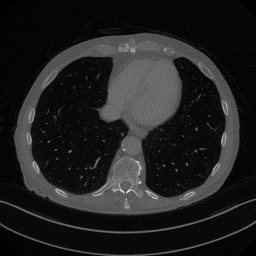

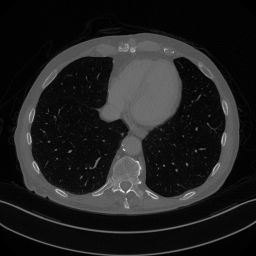

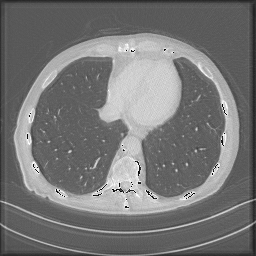

saved_file/ssim_model2_10.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.43960257174851 tensor(0.9978, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.57336048220025 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model2_20.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.44496170014936 tensor(0.9979, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.41807988432587 tensor(0.9975, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model2_30.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.52204840536807 tensor(0.9979, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.553542293486046 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model2_40.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.384336678247486 tensor(0.9978, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.688837567313776 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model2_50.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.575113337302845 tensor(0.9979, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.59048626461967 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model2_60.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.79499555631282 tensor(0.9980, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.40401100330666 tensor(0.9975, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model2_70.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.37923484247447 tensor(0.9978, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.767175451653905 tensor(0.9978, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model2_80.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.70145101148366 tensor(0.9979, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.56639627941319 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model2_90.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.6776204399283 tensor(0.9979, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.681421361985755 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model2_100.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.57399900693857 tensor(0.9978, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.72234753702508 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')


In [5]:
def test_ssim():
    path = 'saved_file/ssim_model_100.pth'
    model.load_state_dict(torch.load(path))
    dataset = CTImage(patch_n=None,patch_size=None,root_dir='../data/TestSet/')
    example,target,_,__ = dataset[6]
    example = example.to(device)
    output = model(example).detach().to('cpu')

    print('pred_psnr:',cal_PSNR(output[0].to(device),target[0].to(device)))
    print('origin_psnr:',cal_PSNR(example[0].to(device),target[0].to(device)))
    print('pred_ssim',cal_SSIM(output[0].to(device),target[0].to(device)))
    print('origin_ssim',cal_SSIM(example[0].to(device),target[0].to(device)))
    transform = transforms.ToPILImage()
    example = transform(example[0])
    target = transform(target[0])
    res = transform(output[0])
    example.show()
    target.show()
    res.show()
    for i in range(10):
        path = 'saved_file/ssim_model2_{}.pth'.format((i+1)*10)
        print(path)
        model.load_state_dict(torch.load(path))
        avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(dataset)
        print('test',avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)
        avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(val_dataset)
        print('val',avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)

test_ssim()

pred_psnr: 43.49529266357422
origin_psnr: 41.10153675079346
pred_ssim tensor(0.9984, device='cuda:0')
origin_ssim tensor(0.9969, device='cuda:0')


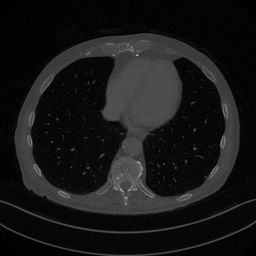

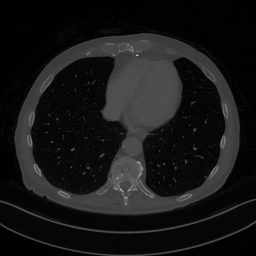

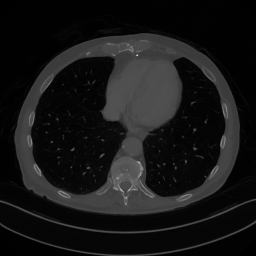

In [11]:
path = 'saved_file/ssim_model2_100.pth'
model.load_state_dict(torch.load(path))
dataset = CTImage(patch_n=None,patch_size=None,root_dir='../data/TestSet/')
example,target,_,__ = dataset[1]
example = example.to(device)
output = model(example).detach().to('cpu')

print('pred_psnr:',cal_PSNR(output[0].to(device),target[0].to(device)))
print('origin_psnr:',cal_PSNR(example[0].to(device),target[0].to(device)))
print('pred_ssim',cal_SSIM(output[0].to(device),target[0].to(device)))
print('origin_ssim',cal_SSIM(example[0].to(device),target[0].to(device)))
transform = transforms.ToPILImage()
example = transform(example[0])
target = transform(target[0])
res = transform(output[0])
example.show()
target.show()
res.show()